# Analyze storrun availablep...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
file = "StorrunDataDump5_29.csv"
df = pd.read_csv(file, low_memory=False)
df['DateTime'] = pd.to_datetime(df['DateTime'], unit='s', utc=True)
df = df.set_index('DateTime')
df = df.resample('1s').first().ffill()

# First-order low-pass filter
alpha = 0.10  # Smoothing factor (smaller = more smoothing)
filtered = [df['avail_activeP'].iloc[0]]  # Initialize with the first signal value

# Apply the filter iteratively
for x in df['avail_activeP'].iloc[1:]:
    filtered.append(alpha * x + (1 - alpha) * filtered[-1])
    
# Add filtered signal to dataframe
df['avail_activeP_lp'] = filtered

df = df.dropna()
df.columns

Index(['POC_activeP', 'WTGA_activeP', 'WTGA_activeP.1', 'avail_activeP',
       'turbine_total_activeP', 'wind_dir', 'wind_speed', 'avail_activeP_lp'],
      dtype='object')

In [43]:
df.head()

,POC_activeP,WTGA_activeP,WTGA_activeP.1,avail_activeP,turbine_total_activeP,wind_dir,wind_speed,avail_activeP_lp
DateTime,,,,,,,,
2025-05-28 16:39:43+00:00,50,-20,-20,380,90,333.35,4.34,380.000
2025-05-28 16:39:44+00:00,60,-20,-20,260,90,333.35,4.34,368.000
2025-05-28 16:39:45+00:00,80,-20,-20,260,100,329.34,4.36,357.200
2025-05-28 16:39:46+00:00,70,-20,-20,330,120,329.81,4.36,354.480
2025-05-28 16:39:47+00:00,70,-20,-20,340,120,330.69,4.37,353.032


Mean Ratio: 0.92


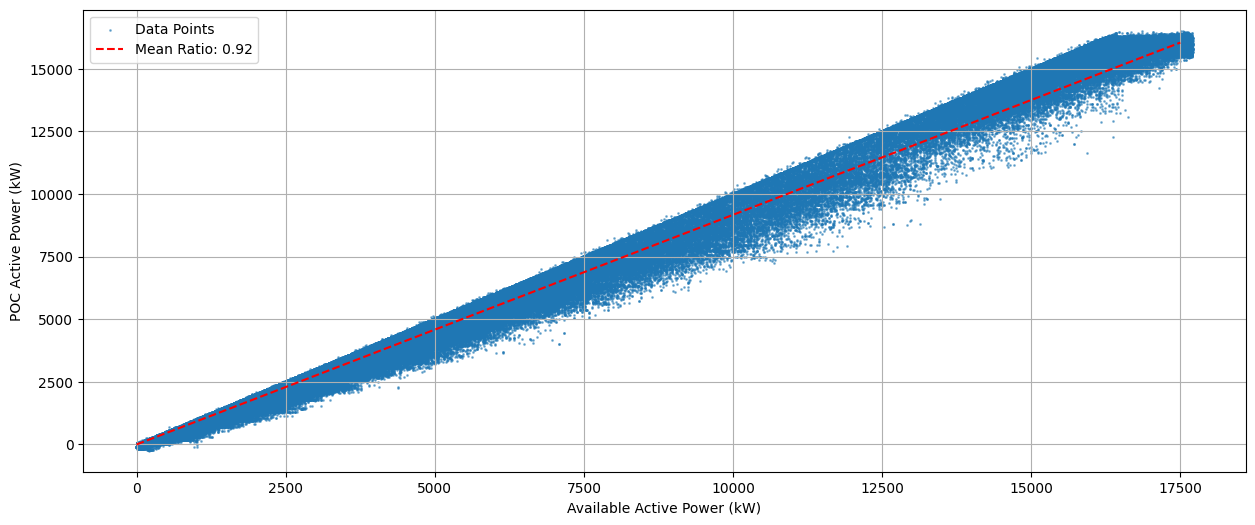

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(df['avail_activeP'], df['POC_activeP'], s=1, alpha=0.5, label='Data Points')
ax.set_xlabel('Available Active Power (kW)'), ax.set_ylabel('POC Active Power (kW)'), ax.grid()
df_ = df[df['avail_activeP'] > 0]
mean_ratio = (df_['POC_activeP'].mean() / df_['avail_activeP'].mean())
print(f'Mean Ratio: {mean_ratio:.2f}')
ax.plot([0, 17500], [0, 17500 * mean_ratio], color='red', linestyle='--', label=f'Mean Ratio: {mean_ratio:.2f}')
ax.legend()

Mean Ratio: 0.92


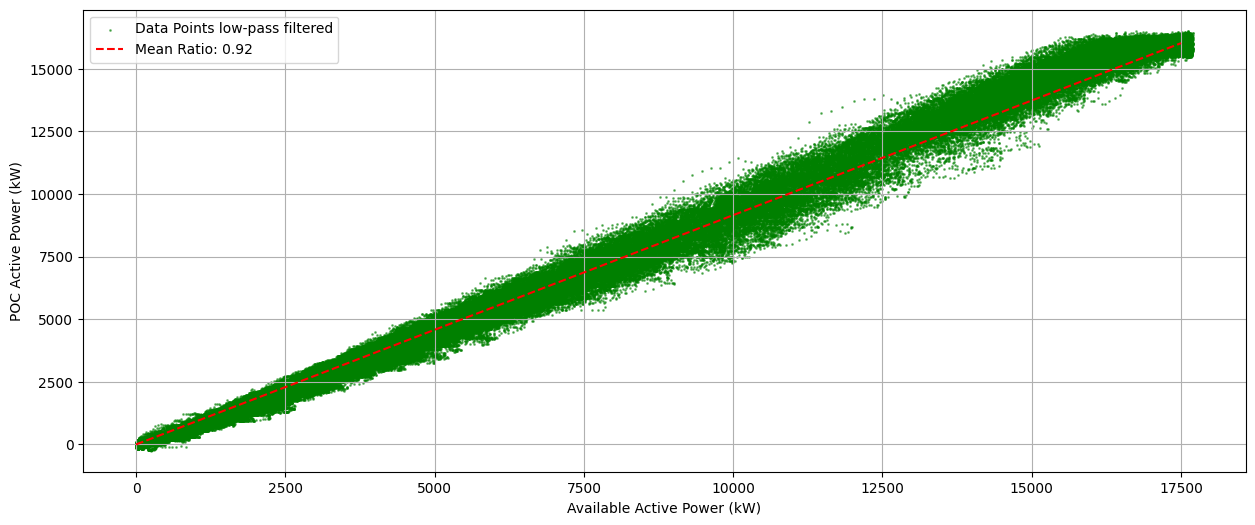

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(df['avail_activeP_lp'], df['POC_activeP'], s=1, alpha=0.5, color='green', label='Data Points low-pass filtered')
ax.set_xlabel('Available Active Power (kW)'), ax.set_ylabel('POC Active Power (kW)'), ax.grid()
df_ = df[df['avail_activeP_lp'] > 0]
mean_ratio = (df_['POC_activeP'].mean() / df_['avail_activeP_lp'].mean())
print(f'Mean Ratio: {mean_ratio:.2f}')
ax.plot([0, 17500], [0, 17500 * mean_ratio], color='red', linestyle='--', label=f'Mean Ratio: {mean_ratio:.2f}')
ax.legend()

## Analyze w.r.t to energy over 15 mins instead

In [58]:
df_energy_15min = df.drop(['WTGA_activeP', 'WTGA_activeP.1', 'wind_dir', 'wind_speed'], axis=1)
df_energy_15min = df_energy_15min.resample('15min').sum()
df_energy_15min['avail_activeP'] = df_energy_15min['avail_activeP'] / 3600  # Convert to kWh
df_energy_15min['POC_activeP'] = df_energy_15min['POC_activeP'] / 3600  # Convert to kWh
df_energy_15min['turbine_total_activeP'] = df_energy_15min['turbine_total_activeP'] / 3600  # Convert to kWh
df_energy_15min['avail_activeP_lp'] = df_energy_15min['avail_activeP_lp'] / 3600  # Convert to kWh
df_energy_15min = df_energy_15min.rename(columns={
    'avail_activeP': 'available_energy',
    'POC_activeP': 'POC_energy',
    'turbine_total_activeP': 'turbine_energy',
    'avail_activeP_lp': 'available_energy_lp'
})
df_energy_15min.columns

Index(['POC_energy', 'available_energy', 'turbine_energy',
       'available_energy_lp'],
      dtype='object')

<Axes: title={'center': 'Storrun Available energy vs POC energy (15min values)'}, xlabel='DateTime'>

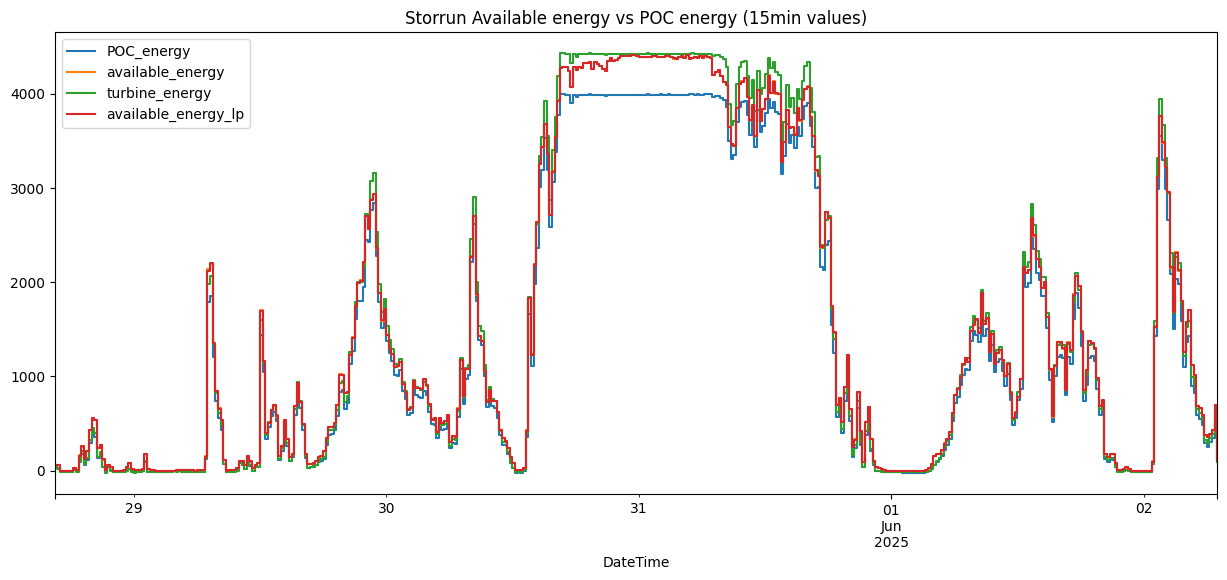

In [59]:
df_energy_15min.plot(figsize=(15, 6), title='Storrun Available energy vs POC energy (15min values)', drawstyle='steps-post')

Mean Ratio: 0.92


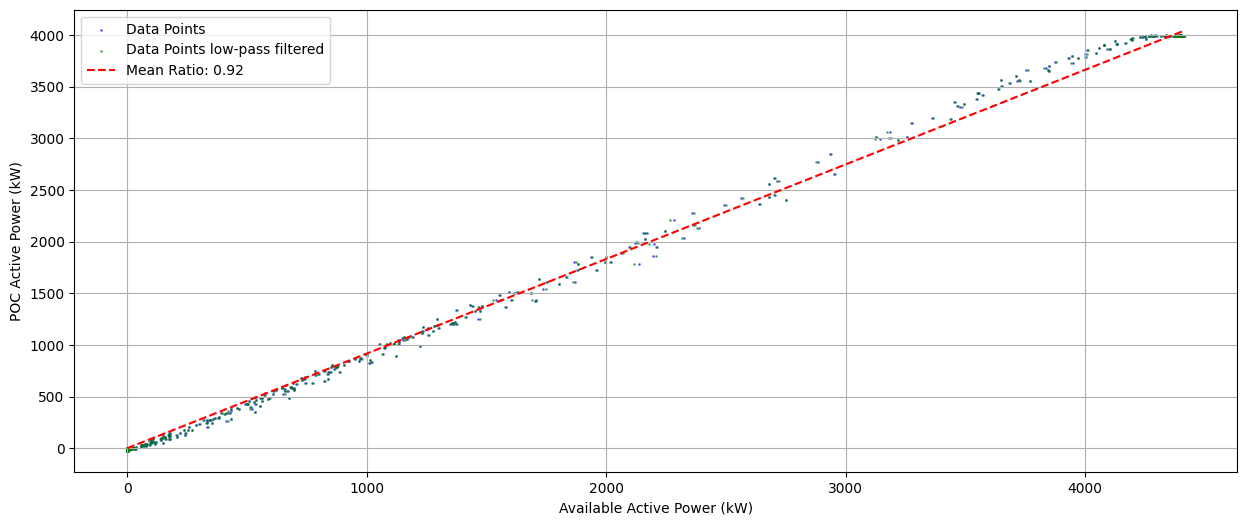

In [63]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(df_energy_15min['available_energy'], df_energy_15min['POC_energy'], s=1, alpha=0.5, color='blue', label='Data Points')
ax.scatter(df_energy_15min['available_energy_lp'], df_energy_15min['POC_energy'], s=1, alpha=0.5, color='green', label='Data Points low-pass filtered')
ax.set_xlabel('Available Active Power (kW)'), ax.set_ylabel('POC Active Power (kW)'), ax.grid()
df_ = df_energy_15min[df_energy_15min['available_energy_lp'] > 0]
mean_ratio = (df_['POC_energy'].mean() / df_['available_energy_lp'].mean())
print(f'Mean Ratio: {mean_ratio:.2f}')
ax.plot([0, df_energy_15min['available_energy_lp'].max()], [0, df_energy_15min['available_energy_lp'].max() * mean_ratio], color='red', linestyle='--', label=f'Mean Ratio: {mean_ratio:.2f}')
ax.legend()

Fitted polynomial:
         3          2
0.03704 x + 0.3294 x - 0.814 x + 2.36


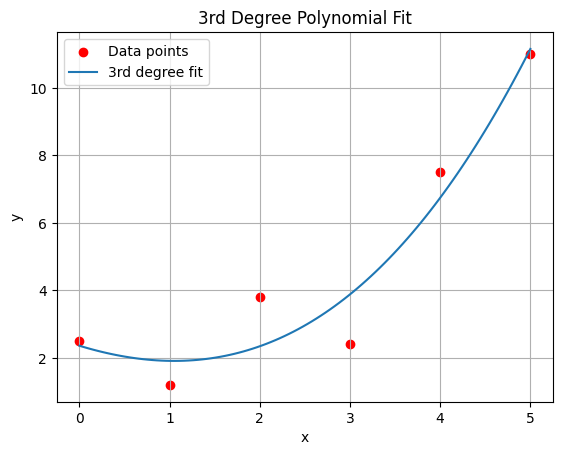

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def fit_poly3(x, y):

    # Fit a 3rd degree polynomial
    coeffs = np.polyfit(x, y, 3)

    # Create a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    return p

# Sample data
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([2.5, 1.2, 3.8, 2.4, 7.5, 11.0])

p = fit_poly3(x, y)

# Print the polynomial equation
print("Fitted polynomial:")
print(p)

# Evaluate and plot the polynomial curve
x_fit = np.linspace(min(x), max(x), 100)
y_fit = p(x_fit)

plt.scatter(x, y, color='red', label='Data points')
plt.plot(x_fit, y_fit, label='3rd degree fit')
plt.legend()
plt.title("3rd Degree Polynomial Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


Mean Ratio: 0.92


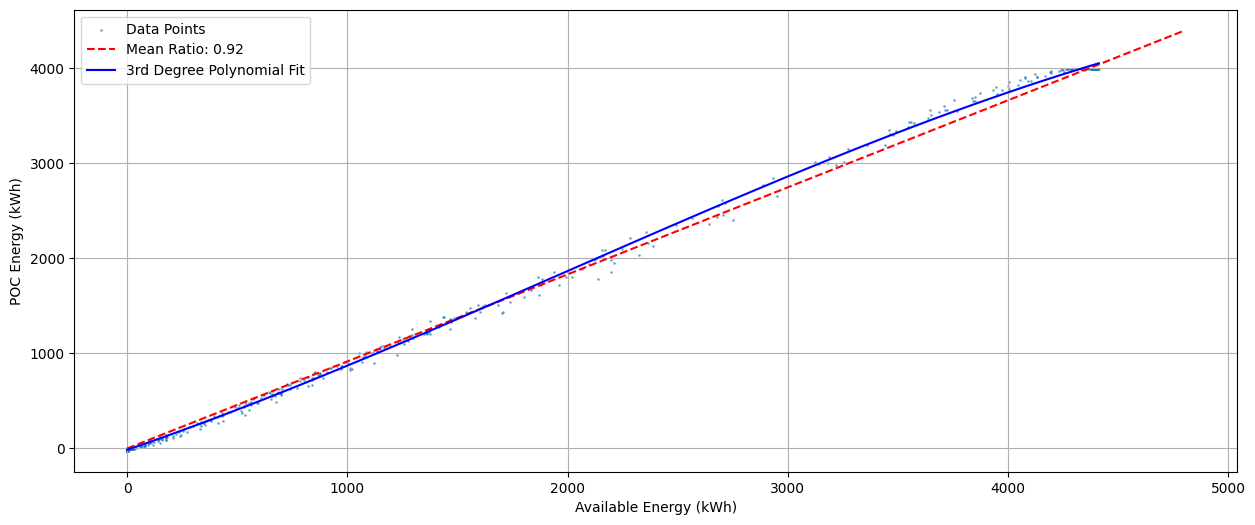

In [53]:
fig,ax = plt.subplots(figsize=(15, 6))
ax.scatter(df_energy_15min['available_energy'], df_energy_15min['active_energy'], s=1, alpha=0.5, label='Data Points')
ax.set_xlabel('Available Energy (kWh)'), ax.set_ylabel('POC Energy (kWh)'), ax.grid()
mean_ratio = (df_energy_15min['active_energy'].mean() / df_energy_15min['available_energy'].mean())
print(f'Mean Ratio: {mean_ratio:.2f}')
ax.plot([0, 4800], [0, 4800 * mean_ratio], color='red', linestyle='--', label=f'Mean Ratio: {mean_ratio:.2f}')
ax.legend()

p = fit_poly3(df_energy_15min['available_energy'], df_energy_15min['active_energy'])
x_fit = np.linspace(df_energy_15min['available_energy'].min(), df_energy_15min['available_energy'].max(), 100)
y_fit = p(x_fit)
ax.plot(x_fit, y_fit, color='blue', label='3rd Degree Polynomial Fit')
ax.legend()